<a href="https://colab.research.google.com/github/sagravat/google-cloudml-workshops/blob/master/notebook_examples/Predict_Helpdesk_Support_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dependencies

In [0]:
project_id = 'agravat-demo'

from google.cloud import bigquery
import os
from google.colab import auth

auth.authenticate_user()

## Create BigQuery Client

In [0]:
client = bigquery.Client(project='agravat-demo')

## Desired Outcome for Our Machine Learning Model

In this tutorial, we'll use a dataset of helpdesk issues to train a model that predicts issue resolution time.

In [0]:
%%bigquery --project agravat-demo
SELECT * FROM `helpdesk.issues` LIMIT 10

,ticketid,contactid,seniority,experience,category,type,impact,priority,resolutiontime
0,t598,Laura Young,5,3-Advanced,Billing,Request,1-Minor,P3,1
1,t784,Brian Marshall,5,4-Trainer,Authentication,Issue,2-Normal,P3,1
2,t1805,Kristina Patrick,5,3-Advanced,Billing,Request,1-Minor,P3,1
3,t3770,Sarah Watkins,5,4-Trainer,Billing,Issue,1-Minor,P3,1
4,t6050,Corey Castro,5,4-Trainer,Authentication,Request,1-Minor,P3,1
5,t6656,Steven Ruiz,5,4-Trainer,Authentication,Issue,3-Major,P3,1
6,t7474,Katherine Turner,5,3-Advanced,Authentication,Issue,1-Minor,P3,1
7,t7485,Yolanda Torres,5,3-Advanced,Authentication,Issue,2-Normal,P3,1
8,t12982,Keith Alvarez,5,3-Advanced,Authentication,Request,2-Normal,P3,1
9,t15644,Amanda Johnson,5,4-Trainer,Authentication,Request,2-Normal,P3,1


## Feature Selection

First we need to select features that we can use to train our model. Always start with fewer and add more as the model improves.

In [0]:
%%bigquery --project agravat-demo
SELECT COUNT(*) FROM `helpdesk.issues`

,f0_
0,100000


In [0]:
%%bigquery --project agravat-demo
SELECT DISTINCT experience, COUNT(*) FROM `helpdesk.issues` GROUP BY experience

,experience,f0_
0,2-Experienced,24924
1,3-Advanced,29367
2,4-Trainer,29099
3,1-Beginner,16610


In [0]:
%%bigquery --project agravat-demo
SELECT DISTINCT category, COUNT(*) FROM `helpdesk.issues` GROUP BY category

,category,f0_
0,Billing,21114
1,Technical,27752
2,Performance,27930
3,Authentication,23204


In [0]:
%%bigquery --project agravat-demo
SELECT DISTINCT type, COUNT(*) FROM `helpdesk.issues` GROUP BY type

,type,f0_
0,Issue,56317
1,Request,43683


In [0]:
%%bigquery --project agravat-demo
SELECT DISTINCT impact, COUNT(*) FROM `helpdesk.issues` GROUP BY impact

,impact,f0_
0,3-Major,20613
1,4-Critical,13090
2,2-Normal,29595
3,0-Unclassified,12063
4,1-Minor,24639


In [0]:
%%bigquery --project agravat-demo
SELECT DISTINCT priority, COUNT(*) FROM `helpdesk.issues` GROUP BY priority

,priority,f0_
0,P3,25000
1,P2,25000
2,P4,25000
3,P1,25000


## Training the First Model

In [0]:
%%bigquery --project agravat-demo
#standardSQL
CREATE OR REPLACE MODEL `helpdesk.predict_time_first` 
OPTIONS(model_type='linear_reg') AS
SELECT
 category,
 type,
 resolutiontime as label
FROM
  `helpdesk.issues`

## Evaluate First Model
Run the query below to evaluate the model just created.

In [0]:
%%bigquery --project agravat-demo
WITH eval_table AS (
    SELECT
    category,
    type,
    resolutiontime as label
    FROM
      `helpdesk.issues` )
SELECT
    *
FROM
    ML.EVALUATE(MODEL `helpdesk.predict_time_first`,
        TABLE eval_table)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.159063,8.868627,0.202651,1.616221,0.17099,0.17099


What do these metrics mean?
![alt text](https://screenshot.googleplex.com/DnQS1D5FDLC.png)

![alt text](https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2009/08/boxplot4.png)



*  ** Mean Absolute Error:** "Average difference between the actual and predicted"
*  ** Mean Squared Error:** used to estimate variance and standard deviation
*   **Mean Squared Log Error:** Similar to the others but better handles outliers
*   **Median Absolute Error:** Similar to Mean Absolute Error and gives a sense of outliers.
*   **R^2:** Should be close to one. This tells us about the strength of the linear relationship. When negative, it means that we're better off using the mean to predict.
*   **Explained Variance:** Tells us how much our model is able to separate the signal from the noise. We want this to be close to 1.



So is our first model any good?

## Training a Second Model
What should we include next? We didn't explore the numerical column seniority.

In [0]:
%%bigquery  --project agravat-demo explore_df
SELECT * EXCEPT(ticketid, contactid) FROM `helpdesk.issues`

,seniority,experience,category,type,impact,priority,resolutiontime
0,5,3-Advanced,Billing,Request,1-Minor,P3,1
1,5,4-Trainer,Authentication,Issue,2-Normal,P3,1
2,5,3-Advanced,Billing,Request,1-Minor,P3,1
3,5,4-Trainer,Billing,Issue,1-Minor,P3,1
4,5,4-Trainer,Authentication,Request,1-Minor,P3,1
5,5,4-Trainer,Authentication,Issue,3-Major,P3,1
6,5,3-Advanced,Authentication,Issue,1-Minor,P3,1
7,5,3-Advanced,Authentication,Issue,2-Normal,P3,1
8,5,3-Advanced,Authentication,Request,2-Normal,P3,1
9,5,4-Trainer,Authentication,Request,2-Normal,P3,1


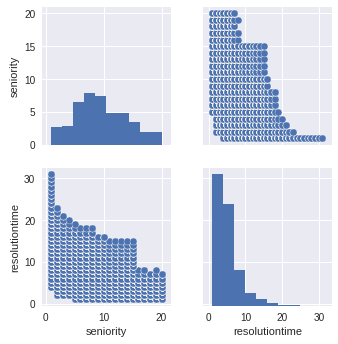

In [0]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
sns.pairplot(explore_df)

In [0]:
%%bigquery --project agravat-demo
CREATE OR REPLACE MODEL `helpdesk.predict_time_second` 
OPTIONS(model_type='linear_reg') AS
SELECT
 category,
 type,
 seniority,
 resolutiontime as label
FROM
  `helpdesk.issues`

## Evaluate Our Second Model
Run the query below to evaluate the model just created.

In [0]:
%%bigquery --project agravat-demo
WITH eval_table AS (
    SELECT
    category,
    type,
    seniority,
    resolutiontime as label
    FROM
      `helpdesk.issues` )
SELECT
    *
FROM
    ML.EVALUATE(MODEL `helpdesk.predict_time_second`,
        TABLE eval_table)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.80696,6.031023,0.162738,1.431247,0.43624,0.43624


## Training a Third Model
It is reasonable to think that a user's experience could affect how long it takes for an issue to be resolved. It also seems reasonable that an issue's priority and impact levels would affect how quickly a support person responds. Let's include these features as well.

In [0]:
%%bigquery --project agravat-demo
CREATE OR REPLACE MODEL `helpdesk.predict_time_third` 
OPTIONS(model_type='linear_reg') AS
SELECT
 category,
 type,
 seniority,
 experience,
 priority,
 impact,
 resolutiontime as label
FROM
  `helpdesk.issues`

## Evaluate Our Third Model
Run the query below to evaluate the model just created.

In [0]:
%%bigquery --project agravat-demo
WITH eval_table AS (
    SELECT
    category,
    type,
    seniority,
    experience,
    priority,
    impact,
    resolutiontime as label
    FROM
      `helpdesk.issues` )
SELECT
    *
FROM
    ML.EVALUATE(MODEL `helpdesk.predict_time_third`,
        TABLE eval_table)

## Get a Prediction
Run the query below to get a prediction for a given issue.

In [0]:
%%bigquery --project agravat-demo
WITH pred_table AS (
SELECT
  1 as seniority,
  '3-Advanced' as experience,
  'Billing' as category,
  'Request' as type,
  'P3' as priority,
  '4-Critical' as impact
)
SELECT
  *
FROM
  ML.PREDICT(MODEL `helpdesk.predict_time_third`,
    TABLE pred_table)


## How much does category affect the resolution time?


In [0]:
%%bigquery --project agravat-demo
SELECT
  category,
  weight
FROM
  UNNEST((
    SELECT
      category_weights
    FROM
      ML.WEIGHTS(MODEL `helpdesk.predict_time_second`)
    WHERE
      processed_input = 'category'))

## Training a Fourth Model
What if we include an interaction term?

In [0]:
%%bigquery --project agravat-demo
CREATE OR REPLACE MODEL `helpdesk.predict_time_fourth` 
OPTIONS(model_type='linear_reg') AS
SELECT
    category,
    type,
    seniority,
    experience,
    priority,
    CAST(REPLACE(priority,'P','') as INT64) * seniority as seniority_priority,
    impact,
    resolutiontime as label
FROM
  `helpdesk.issues`

## Evaluate Our Fourth Model
Run the query below to evaluate the model just created.

In [0]:
%%bigquery --project agravat-demo
WITH eval_table AS (
    SELECT
    category,
    type,
    seniority,
    experience,
    priority,
    CAST(REPLACE(priority,'P','') as INT64) * seniority as seniority_priority,
    impact,
    resolutiontime as label
    FROM
      `helpdesk.issues` )
SELECT
    *
FROM
    ML.EVALUATE(MODEL `helpdesk.predict_time_fourth`,
        TABLE eval_table)

## Training a Fifth Model
What if we standardize our numeric columns?

In [0]:
%%bigquery --project agravat-demo
CREATE OR REPLACE MODEL `helpdesk.predict_time_fifth` 
OPTIONS(model_type='linear_reg') AS
SELECT
    category,
    type,
    LOG(seniority) as seniority,
    experience,
    priority,
    LOG(CAST(REPLACE(priority,'P','') as INT64) * seniority) as seniority_priority,
    impact,
    resolutiontime as label
FROM
  `helpdesk.issues`

## Evaluate Our Fifth Model
Run the query below to evaluate the model just created.

In [0]:
%%bigquery --project agravat-demo
WITH eval_table AS (
    SELECT
    category,
    type,
    LOG(seniority) as seniority,
    experience,
    priority,
    LOG(CAST(REPLACE(priority,'P','') as INT64) * seniority) as seniority_priority,
    impact,
    resolutiontime as label
    FROM
      `helpdesk.issues` )
SELECT
    *
FROM
    ML.EVALUATE(MODEL `helpdesk.predict_time_fifth`,
        TABLE eval_table)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.060852,2.247471,0.067934,0.804342,0.789914,0.790012
